# Neural networks with TensorFlow Keras

### Steps
1. Import the necessary packages
2. Get the data
3. Set up the network architecture
4. Train the network 
5. Hyperparameter tuning
6. Use the trained network



### Import the necessary packages

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, Model, models, optimizers, metrics, callbacks
from functools import partial
import keras_tuner as kt
from sklearn.metrics import multilabel_confusion_matrix

### Get the data

In [ ]:
# load the mnist dataset, already split in training and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() 
# http://yann.lecun.com/exdb/mnist/
x_train.shape, y_train.shape, x_test.shape, y_test.shape

### Preprocess the data

In [ ]:
# preprocess the images
# scale images to the range between 0 and 1
print('original pixel value', x_train[0,5,14])
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print('normalised pixel value', x_train[0,5,14])

# Make sure images have shape (num_samples, flattened image)
print('original X shape', x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print('X shape with flattened image', x_train.shape)

input_shape = x_train.shape[-1]  # image shape, 1 denotes the number of colour channels: greyscale has one channel

In [ ]:
# preprocess the labels (0..9)
num_classes = len(set(y_train))  # 10 classes, one for each digit

# use one-hot encoding to binarise the labels
print('label (shown digit): ', y_train[0])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('one-hot encoded label', y_train[0])

### One-hot encoding
Transform integer labels, e.g. 0..9, into binary labels

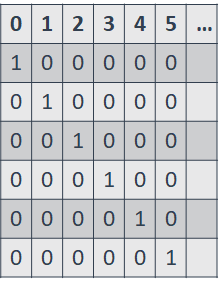


Softmax output

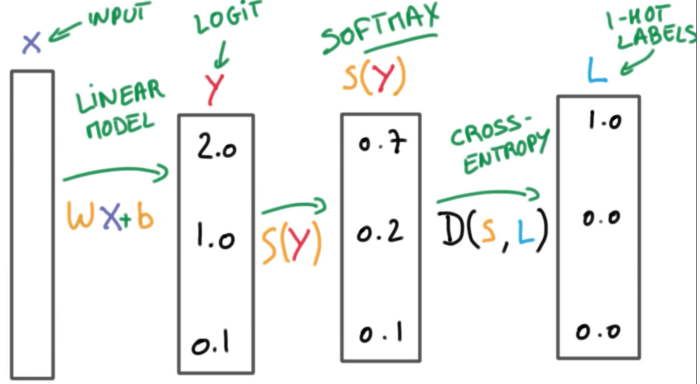

## Set up the network

### Principal network setup using the sequential API

```
model = keras.Sequential([
input_ = layers.Input(shape=input_shape),  
dense_1 = layers.Dense(_), 
dense_2 = layers.Dense(_),  
dense_3 = layers.Dense(_),  
output = layers.Dense(_),  
model = Model(inputs=[input_], outputs=[output]), 
])
```

https://keras.io/api/layers/core_layers/dense/

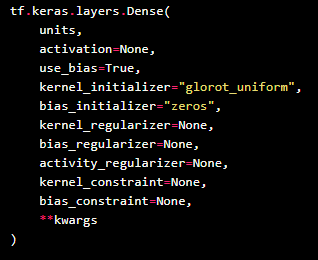


In [ ]:
model = keras.Sequential([
    layers.Input(shape=input_shape), 
    layers.Dense(1000, activation='ELU', kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1)),
    layers.Dense(1000, activation='ELU', kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1)),
    layers.Dense(500, activation='ELU', kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1)),
    layers.Dense(num_classes, activation='softmax', bias_initializer=initializers.Constant(0.1)),
])

# print the architecture
model.summary()

In [ ]:
# train the network 
batch_size = 128
epochs = 10
SGD = optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=SGD, 
              metrics=["accuracy", metrics.Precision(), metrics.Recall()])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

### Precision & Recall

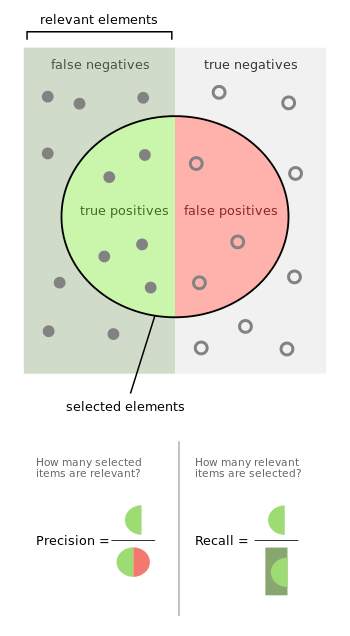

Precision: validity  
Recall: completeness, sensitivity

F1 score: $ 2 * \frac{precision * recall}{precision + recall} $ (harmonic mean of the precision and recall)

In [ ]:
# Analyse the results

print('Model metrics: ', model.metrics_names)
print('Run the trained network with the test data: ')
test_run = model.evaluate(x_test, y_test)

# compute the F1 score
precision = history.history['val_precision'][-1] 
recall = history.history['val_recall'][-1] 
f1_val = 2 * (precision * recall) / (precision + recall)
f1_test = 2 * (test_run[2] * test_run[3]) / (test_run[2] + test_run[3])

print('Test results: ', test_run)
print('F1 score validation: ', f1_val)
print('F1 score test: ', f1_test)


### Simplify the layer declaration using functool
https://docs.python.org/3/library/functools.html

In [ ]:
from functools import partial

In [ ]:
denseLayer = partial(layers.Dense, 
                     kernel_initializer='he_normal',
                     bias_initializer=initializers.Constant(0.1),
                     activation='ELU')

In [ ]:
model = keras.Sequential([
    layers.Input(shape=input_shape), 
    denseLayer(1000),
    denseLayer(1000),
    denseLayer(500),
    denseLayer(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
])

### Set up the network training with an exponentially decaying learning rate

In [ ]:
# train the network 
tf.keras.backend.clear_session()  # clear the previous runs
batch_size = 128
epochs = 10

lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, 
                                                    decay_steps=100, decay_rate=0.9)
SGD = optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=SGD, 
              metrics=["accuracy", metrics.Precision(), metrics.Recall()])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)
print('test')
model.evaluate(x_test, y_test)

### Principal network setup using the functional API

```
input_ = layers.Input(shape=input_shape)  
dense_1 = layers.Dense(_)(input_)  
dense_2 = layers.Dense(_)(dense_1)  
dense_3 = layers.Dense(_)(dense_2)  
output = layers.Dense(_)(dense_3)  
model = Model(inputs=[input_], outputs=[output])  
```

In [ ]:
# network architecture
input_ = layers.Input(shape=input_shape)  
dense_1 = denseLayer(1000)(input_)  
dense_2 = denseLayer(1000)(dense_1)  
dense_3 = denseLayer(500)(dense_2)  
output = denseLayer(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(dense_3)  
model = Model(inputs=[input_], outputs=[output])

# print the architecture
model.summary()


### Set up the network with additional callbacks

In [ ]:
# train the network 
tf.keras.backend.clear_session()  # clear the previous runs
batch_size = 128
epochs = 10

lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, 
                                                          decay_steps=100, decay_rate=0.9)
SGD = optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# save the trained model, but only the best one
checkpoint_cb = callbacks.ModelCheckpoint('tuned_network.h5', save_best_only=True, monitor='val_accuracy', mode='max')
# stop as soon as overfitting is spotted
early_stopping_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model.compile(loss="categorical_crossentropy", optimizer=SGD, 
              metrics=["accuracy", metrics.Precision(), metrics.Recall()])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3, 
                    callbacks=[checkpoint_cb, early_stopping_cb])
print('test')
model.evaluate(x_test, y_test)

## Hyperparameter tuning

In [ ]:
import keras_tuner as kt

### First, let's rewrite the network as a fuction

In [ ]:
def build_model(hp):
    # to be tuned hyperparameters
    learning_rate = hp.Float('learning_rate', 1e-04, 0.01, sampling='log')
    # sampling acts as a hint for an initial prior probability distribution for how this value should be sampled, 
    # e.g. "log" will assign equal probabilities to each order of magnitude range
    num_neurons_dense_1 = hp.Choice('dense1', [100, 1000])
    
    # network 
    SGD = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    input_ = layers.Input(shape=input_shape)  
    dense_1 = layers.Dense(num_neurons_dense_1)(input_)  
    dense_2 = layers.Dense(1000)(dense_1)  
    dense_3 = layers.Dense(1000)(dense_2)  
    output = layers.Dense(num_classes, activation='softmax')(dense_3)  
    model = Model(inputs=[input_], outputs=[output])
    
    model.compile(loss="categorical_crossentropy", optimizer=SGD, 
                  metrics=["accuracy", metrics.Precision(), metrics.Recall()])
    return model

### Then set up the tuner 

In [ ]:
tf.keras.backend.clear_session()  # clear the previous runs
batch_size = 128
epochs = 5

checkpoint_cb = callbacks.ModelCheckpoint('tuned_network.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping_cb = callbacks.EarlyStopping(patience=2, restore_best_weights=True)

tuner = kt.BayesianOptimization(hypermodel=build_model, objective='val_accuracy', max_trials=5)
print(tuner.search_space_summary(extended=True))

tuner.search(x_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[checkpoint_cb, early_stopping_cb], verbose=2)

print(tuner.results_summary())

Note that keras tuner saves the tuning results in the notebook's directory in a folder titled *untitled_projects*. So, if you want to start the hyperparameter search anew or with new hyperparameters you should rename or delete the folder, otherwise keras tuner will restart the previous hyperparameter optimisation.

### Confusion matrix
Compute a one-vs-rest confusion matrix for all class categories using the saved, best network from hyperparameter tuning

In [ ]:
model = models.load_model('tuned_network.h5')
predictions = model.predict(x_test)

confusion_matrix = multilabel_confusion_matrix(y_test, tf.where(predictions <= 0.5, 0, 1))
confusion_matrix

### Excercises
- Set up your own network architecture 
    - Number of layers
    - Number of neurons / units per layer
    - Activation function
    - Optimiser
    - Learning rate (schedule)
    - Batch size
- What hyperparameter changes influence network performance the most? What hyperparameter changes result in a large difference between **training** and **validation** loss/accuracy?
- Tune the learning rate and see how high you can get the **training** loss
- How does the train / validation split influence network performance? 
- Use hyperparameter tuning to achieve an as low as possible **validation** loss / as high as possible validation accuracy / F1 score (or even better, test accuracy / F1 score). Tune sensible combinations, like number of neurons in each layer and / or number of layers or optimiser method, learning rate and optimiser hyperparameters

Optional:
- Load the Boston housing dataset (https://keras.io/api/datasets/) and set up a regression network. What output activation function do you need? What loss and metric are suitable?